In [35]:
# Importación de librerías
import cv2
import numpy as np
import scipy.misc
from scipy.fftpack import dct
from scipy.fftpack import idct
#from scipy.fftpack import normalize
import pywt
from skimage.transform import pyramids, pyramid_gaussian, pyramid_laplacian
from matplotlib import pyplot as plt
from numba import jit
from os import listdir, path
import pyrtools as pt

In [36]:
# Agregar data set
image_dataset = []

ABSOLUTE_PATH = "D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/PreprocesamientoImagenes/Contrast-Enhancer/images"
for img_path in listdir(ABSOLUTE_PATH):
    image_dataset.append(cv2.resize(cv2.imread(path.join(ABSOLUTE_PATH, img_path), 0), (256, 256)))

# Imprimir el número de imágenes en el dataset
print("Número de imágenes en el dataset: ", len(image_dataset))

Número de imágenes en el dataset:  11


Text(0.5, 1.0, 'Última imagen del dataset')

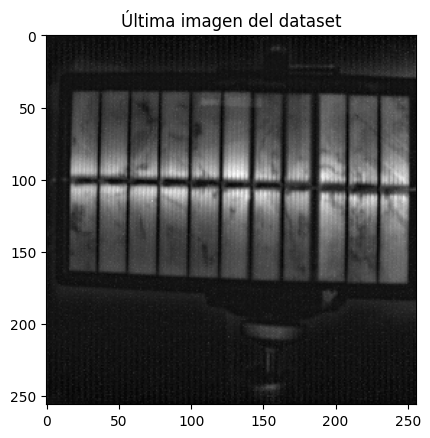

In [37]:
# Mostrar la primera imagen del dataset
plt.imshow(image_dataset[10], cmap='gray')
plt.title("Última imagen del dataset")

In [39]:
# Funciones que realizan operaciones sobre las imágenes

def normalize(img):
  """
  Normaliza una imagen.

  Parámetros:
    img: Imagen a normalizar.

  Retorno:
    Imagen normalizada con valores de píxeles en el rango [0, 255].
  """
  mx = np.amax(img)
  img /= mx
  img *= 255
  img = img.astype(np.uint8)
  return img

def dct2d(img):
  """
  Aplica la transformada discreta del coseno 2D a una imagen.

  Parámetros:
    img: Imagen a la que se le aplicará la transformada.

  Retorno:
    Imagen en el dominio de la frecuencia.
  """
  img = img.astype(np.float32) / 255.0
  return dct(dct(img.T, norm='ortho').T, norm='ortho') * 255.0


def idct2d(img):
  """
  Aplica la transformada discreta del coseno inversa 2D a una imagen.

  Parámetros:
    img: Imagen a la que se le aplicará la transformada inversa.

  Retorno:
    Imagen con la transformada inversa aplicada. Imagen en el 
    dominio del espacio, que es la inversa de la operación 
    realizada por dct2d(img).
  """
  img = img.astype(np.float32) / 255.0
  return idct(idct(img.T, norm='ortho').T, norm='ortho') * 255.0




A conotinuación se definen dos clases.
* La clase `Base` define la estructura básica y la función `apply_enhancement` para mejorar la imagen.
* La clase `DCTPyramidal` hereda de `Base` y implementa la transformada piramidal DCT sobre la imagen.

**Uso:**

* Crea una instancia de la clase `DCTPyramidal` con la imagen y el número de etapas deseados.
* Llama a la función `get_result()` para obtener la imagen transformada.

**Ejemplo:**

```python
img = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
dct_pyramid = DCTPyramidal(img, stage=3)
enhanced_img = dct_pyramid.get_result()
```

In [40]:
class Base(object):
  def __init__(self, img, stage=5):
    self.img = img
    self.result = None
    self.before_img_pyramid = []
    self.after_img_pyramid = []
    self.stage = stage

  def apply_enhancement(self, img):
      scaling_factor = 255.0 / img.max()
      hist_img = cv2.equalizeHist(np.uint8(img * scaling_factor)) / scaling_factor

      U, s, Vth = np.linalg.svd(img)
      Ul, sl, Vlth = np.linalg.svd(hist_img)

      E = np.max(sl) / np.max(s)
      alpha = (E + 1 / E) / 4
      S = alpha * ((E * s) + (sl / E))
      sigma = np.diag(S)

      enhanced_img = U @ sigma @ Vth
      return enhanced_img

  def transform(self, img):
    raise NotImplementedError("Este método debe ser implementado en la subclase.")

  def get_result(self):
    self.result = self.transform(self.img)

class DCTPyramidal(Base):
  def transform(self, img):
    if img.size == 1 or self.stage == 0:
      return img
    self.stage -= 1

    img_dct = dct2d(img)
    h, w = img_dct.shape

    LL = img_dct[:h // 2, :w // 2]
    img_LL = idct2d(LL)
    enhanced_img_LL = self.transform(img_LL)
    enhanced_img_LL_dct = dct2d(enhanced_img_LL)

    img_dct[:h // 2, :w // 2] = enhanced_img_LL_dct
    img = idct2d(img_dct)
    img = self.apply_enhancement(img)  # Reutilizar la función apply_enhancement
    return img


In [41]:
# Sobre-muestreo de una imagen
def upsample(img):
  """
  Realiza un sobre-muestreo de una imagen.

  Parámetros:
    img: Imagen a la que se le aplicará el sobre-muestreo.

  Retorno:
    Imagen con el sobre-muestreo aplicado.
  """
  return cv2.pyrUp(img, interpolation=cv2.INTER_LINEAR)


Text(0.5, 1.0, 'Imagen original')

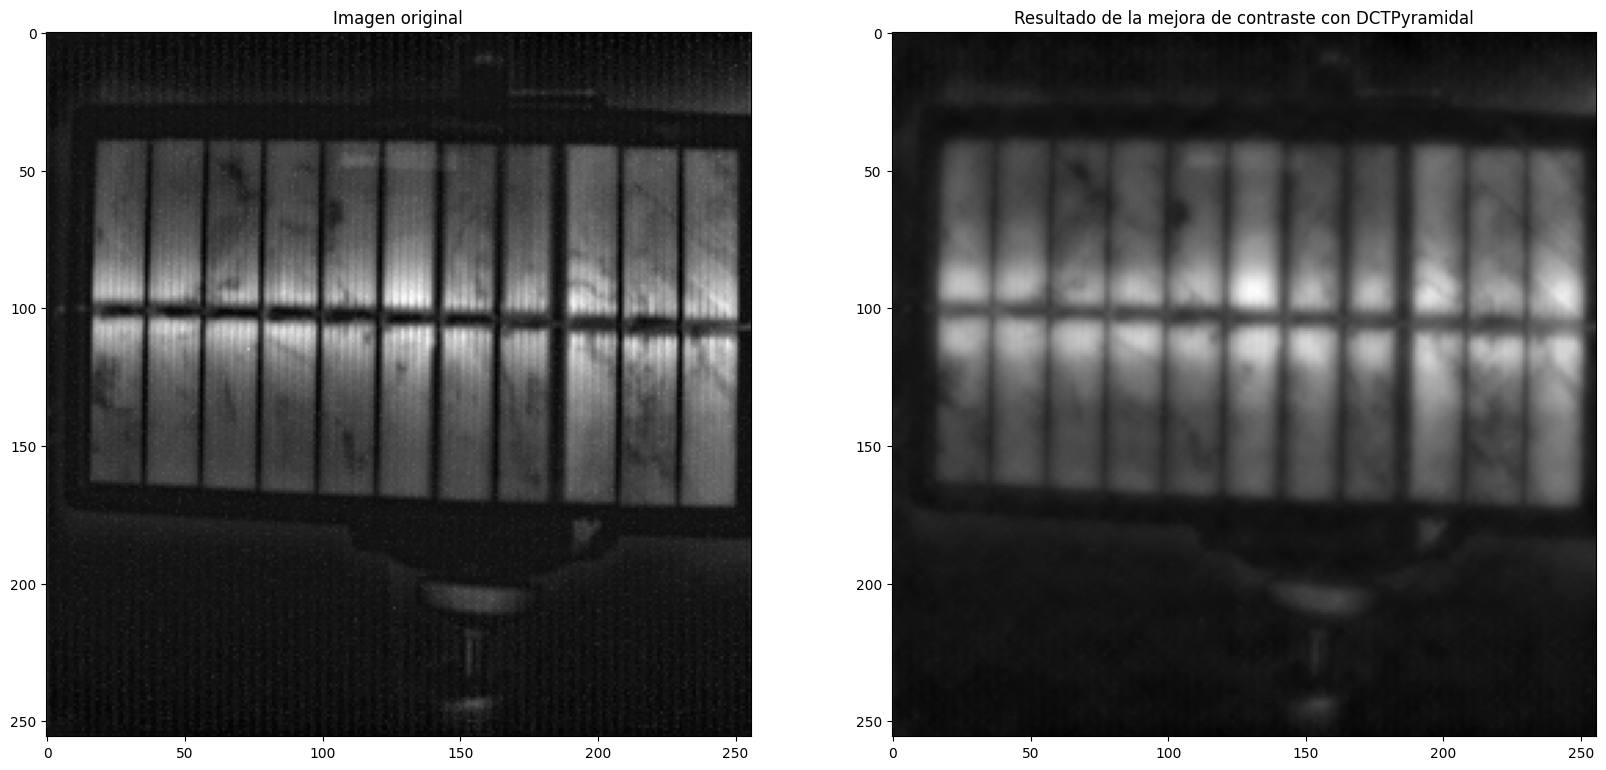

In [44]:
# Prueba de DCTPyramidal
lena_dark = image_dataset[10]
model = DCTPyramidal(lena_dark,stage=5)
model.get_result()
result = model.result
# plt.imshow(result, cmap="gray")

# Comparación de la imagen original y la imagen mejorada con DCTPyramidal
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 2)
plt.imshow(result, cmap="gray")
plt.title("Resultado de la mejora de contraste con DCTPyramidal")
plt.subplot(1, 2, 1)
plt.imshow(lena_dark, cmap="gray")
plt.title("Imagen original")

La clase `DWTPyramidal` hereda de una clase base llamada `Base` y define una función de transformación que aplica la Transformada de Wavelet Discreta (DWT) y la Transformada de Wavelet Discreta Inversa (IDWT) en una imagen.

La función `transform` toma una imagen como entrada y realiza las siguientes operaciones:

1. Comprueba si el tamaño de la imagen es 1 o si el atributo `stage` de la clase es 0. Si alguna de estas condiciones es verdadera, la función devuelve la imagen tal cual, sin realizar ninguna transformación.

2. Si ninguna de las condiciones anteriores es verdadera, disminuye el valor de `stage` en 1.

3. Aplica la DWT a la imagen utilizando la función `pywt.dwt2` con "bior1.3" como la wavelet madre. Esta función devuelve una tupla de coeficientes que se desempaqueta en `LL` (la imagen de baja frecuencia) y `(LH, HL, HH)` (las imágenes de alta frecuencia).

4. Llama a la función `transform` de forma recursiva en `LL`, lo que permite aplicar la transformación en múltiples niveles de la imagen. El resultado se almacena en `enhanced_LL`.

5. Crea una nueva tupla de coeficientes con `enhanced_LL` y las imágenes de alta frecuencia `(LH, HL, HH)`.

6. Aplica la IDWT a los coeficientes utilizando la función `pywt.idwt2` con "bior1.3" como la wavelet madre. El resultado se almacena en `ret`.

7. Aplica una función de mejora (definida en la clase base `Base`) a `ret`.

8. Recorta `ret` para que tenga las mismas dimensiones que la imagen original.

9. Devuelve `ret`.

Esta clase realiza una transformación piramidal de wavelet discreta en una imagen, lo que puede ser útil para el análisis multiresolución de la imagen.

In [48]:
class DWTPyramidal(Base):
    """ Clase que implementa la pirámide de wavelet discreta. 

    Atributos:
        stage: Número de etapas de la pirámide.
    """
    def transform(self, img):
        """
        Aplica la transformación wavelet discreta a una imagen.
        
        Parámetros:
            img: Imagen a la que se le aplicará la transformación.

        Retorno:
            Imagen con la transformación wavelet discreta aplicada.
        """
        if img.size == 1 or self.stage == 0:
            return img
        self.stage -= 1

        coeffs2 = pywt.dwt2(img, "bior1.3")
        LL, (LH, HL, HH) = coeffs2
        enhanced_LL = self.transform(LL)

        coeffs2 = enhanced_LL, (LH, HL, HH)

        ret = pywt.idwt2(coeffs2, "bior1.3")
        ret = self.apply_enhancement(ret)
        ret = ret[:img.shape[0], :img.shape[1]]
        return ret

Text(0.5, 1.0, 'Imagen original')

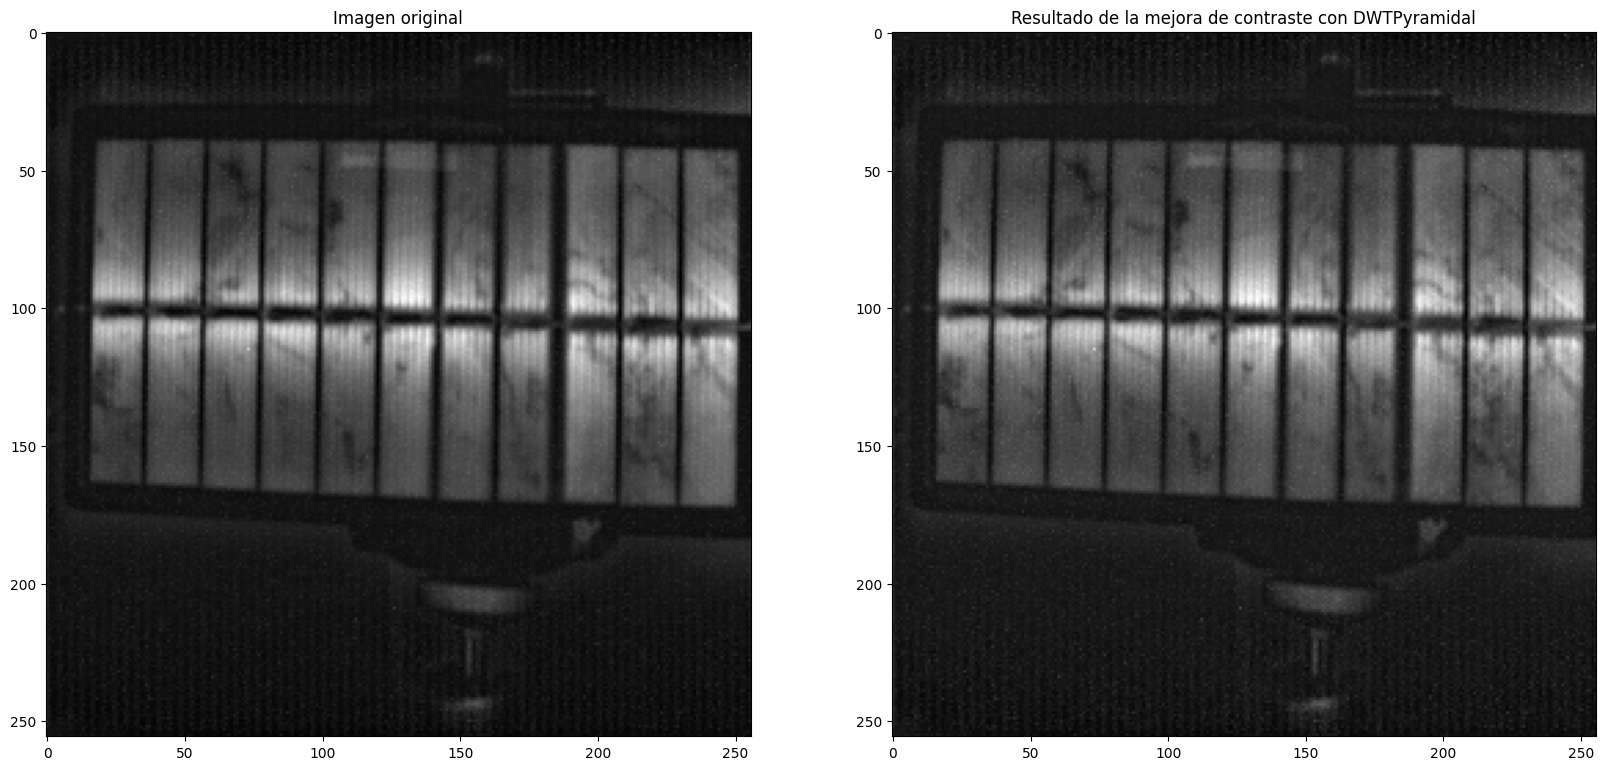

In [51]:
# Prueba de DWTPyramidal
panel1 = image_dataset[10]
model = DWTPyramidal(panel1, 1)
model.get_result()

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 2)
plt.imshow(model.result, cmap="gray")
plt.title("Resultado de la mejora de contraste con DWTPyramidal")

plt.subplot(1, 2, 1)
plt.imshow(panel1, cmap="gray")
plt.title("Imagen original")

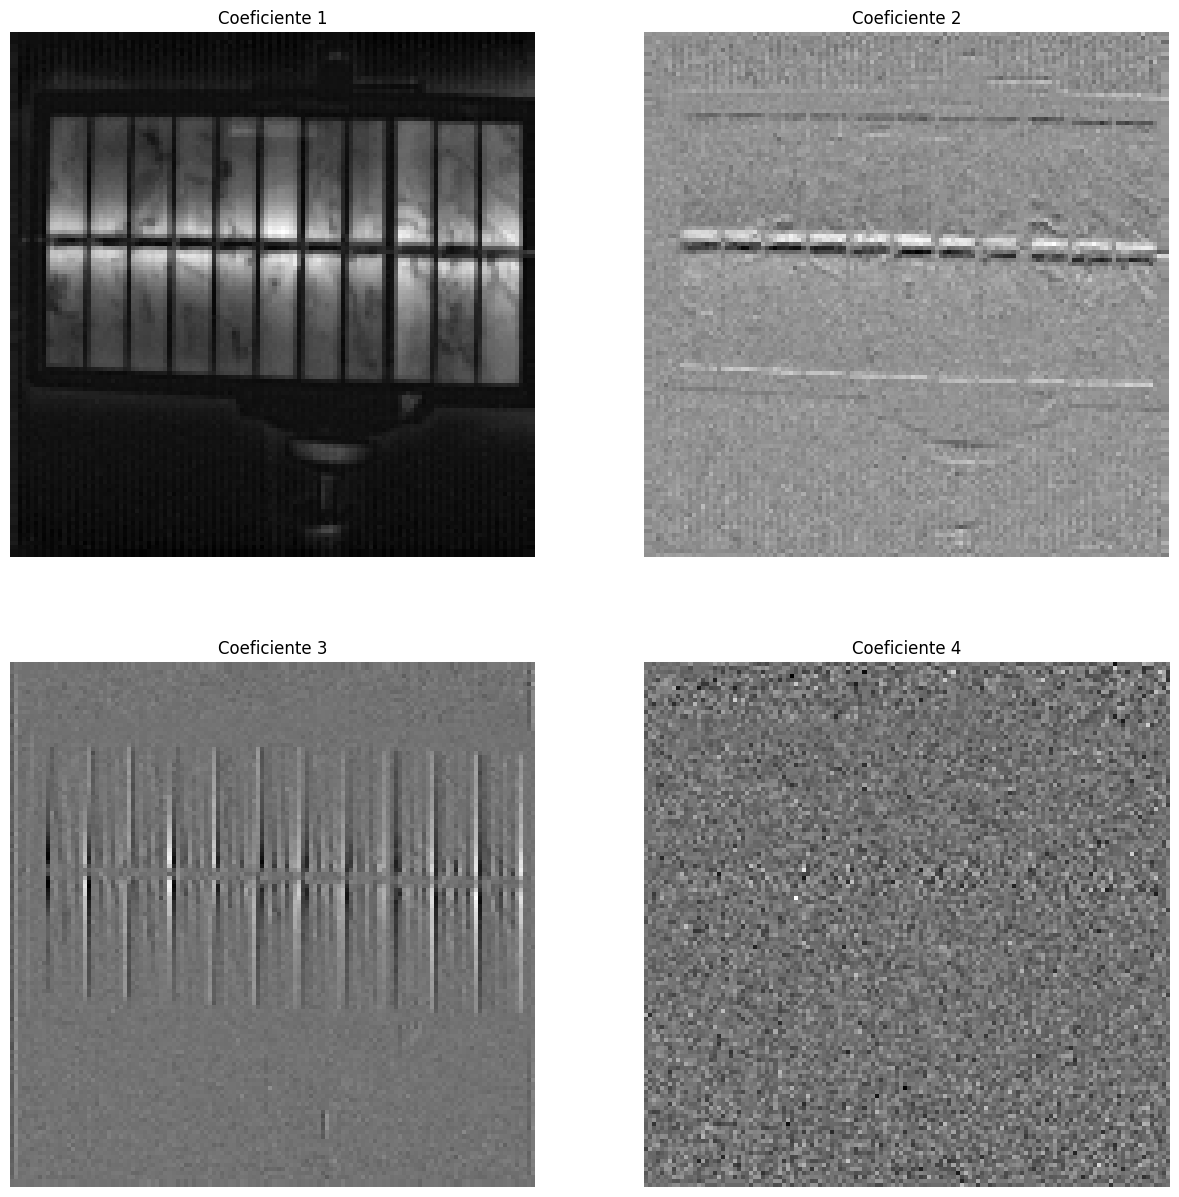

In [52]:
# Aplica la DWT a una imagen y visualiza los coeficientes de la transformada en una cuadrícula de 2x2.

coeffs2 = pywt.dwt2(image_dataset[-1], 'bior1.3')       # Aplica la DWT a la imagen
LL, (LH, HL, HH) = coeffs2                              # Obtiene los coeficientes de la transformada

plt.figure(figsize=(15, 15))
for i, a in enumerate([LL, LH, HL, HH]):                # Itera sobre los coeficientes
    plt.subplot(2, 2, i + 1)
    plt.imshow(a, cmap='gray')
    plt.title(f"Coeficiente {i + 1}")
    plt.axis("off")



El siguiente código realiza una serie de operaciones de reducción y expansión de pirámides en una imagen y luego visualiza los resultados.  

1. `reduced = pyramids.pyramid_reduce(image_dataset[-1], sigma=None)`: Esta línea toma la última imagen del conjunto de datos image_dataset y la reduce utilizando la función *pyramid_reduce* de la biblioteca pyramids. La reducción de pirámide es una operación que disminuye el tamaño de la imagen. En este caso, la función reduce a la mitad el tamaño de la imagen en cada dimensión, resultando en una imagen que es una cuarta parte del tamaño de la imagen original (mitad de ancho y mitad de alto).

2. `expanded = pyramids.pyramid_expand(reduced, sigma=None)`: Esta línea toma la imagen reducida y la expande utilizando la función *pyramid_expand* de la biblioteca pyramids. La expansión de pirámide es una operación que aumenta el tamaño de la imagen. En este caso, la función duplica el tamaño de la imagen en cada dimensión, resultando en una imagen que es cuatro veces el tamaño de la imagen reducida (doble ancho y doble alto).

3. `red = pyramids.pyramid_reduce(expanded, sigma=None)`: Esta línea toma la imagen expandida y la reduce nuevamente.

4. d`iff = red - reduced`: Esta línea calcula la diferencia entre la imagen reducida original y la imagen que ha sido expandida y luego reducida. Esta diferencia se conoce como la "imagen laplaciana" y puede ser útil para resaltar los detalles de la imagen.

5. Las siguientes líneas crean una figura y tres subplots para visualizar la imagen reducida, la imagen original y la imagen laplaciana. La función *imshow* se utiliza para mostrar las imágenes en escala de grises y la función *title* se utiliza para establecer los títulos de los subplots.

Dimensiones del laplaciano:  (128, 128)


Text(0.5, 1.0, 'Imagen Laplaciana')

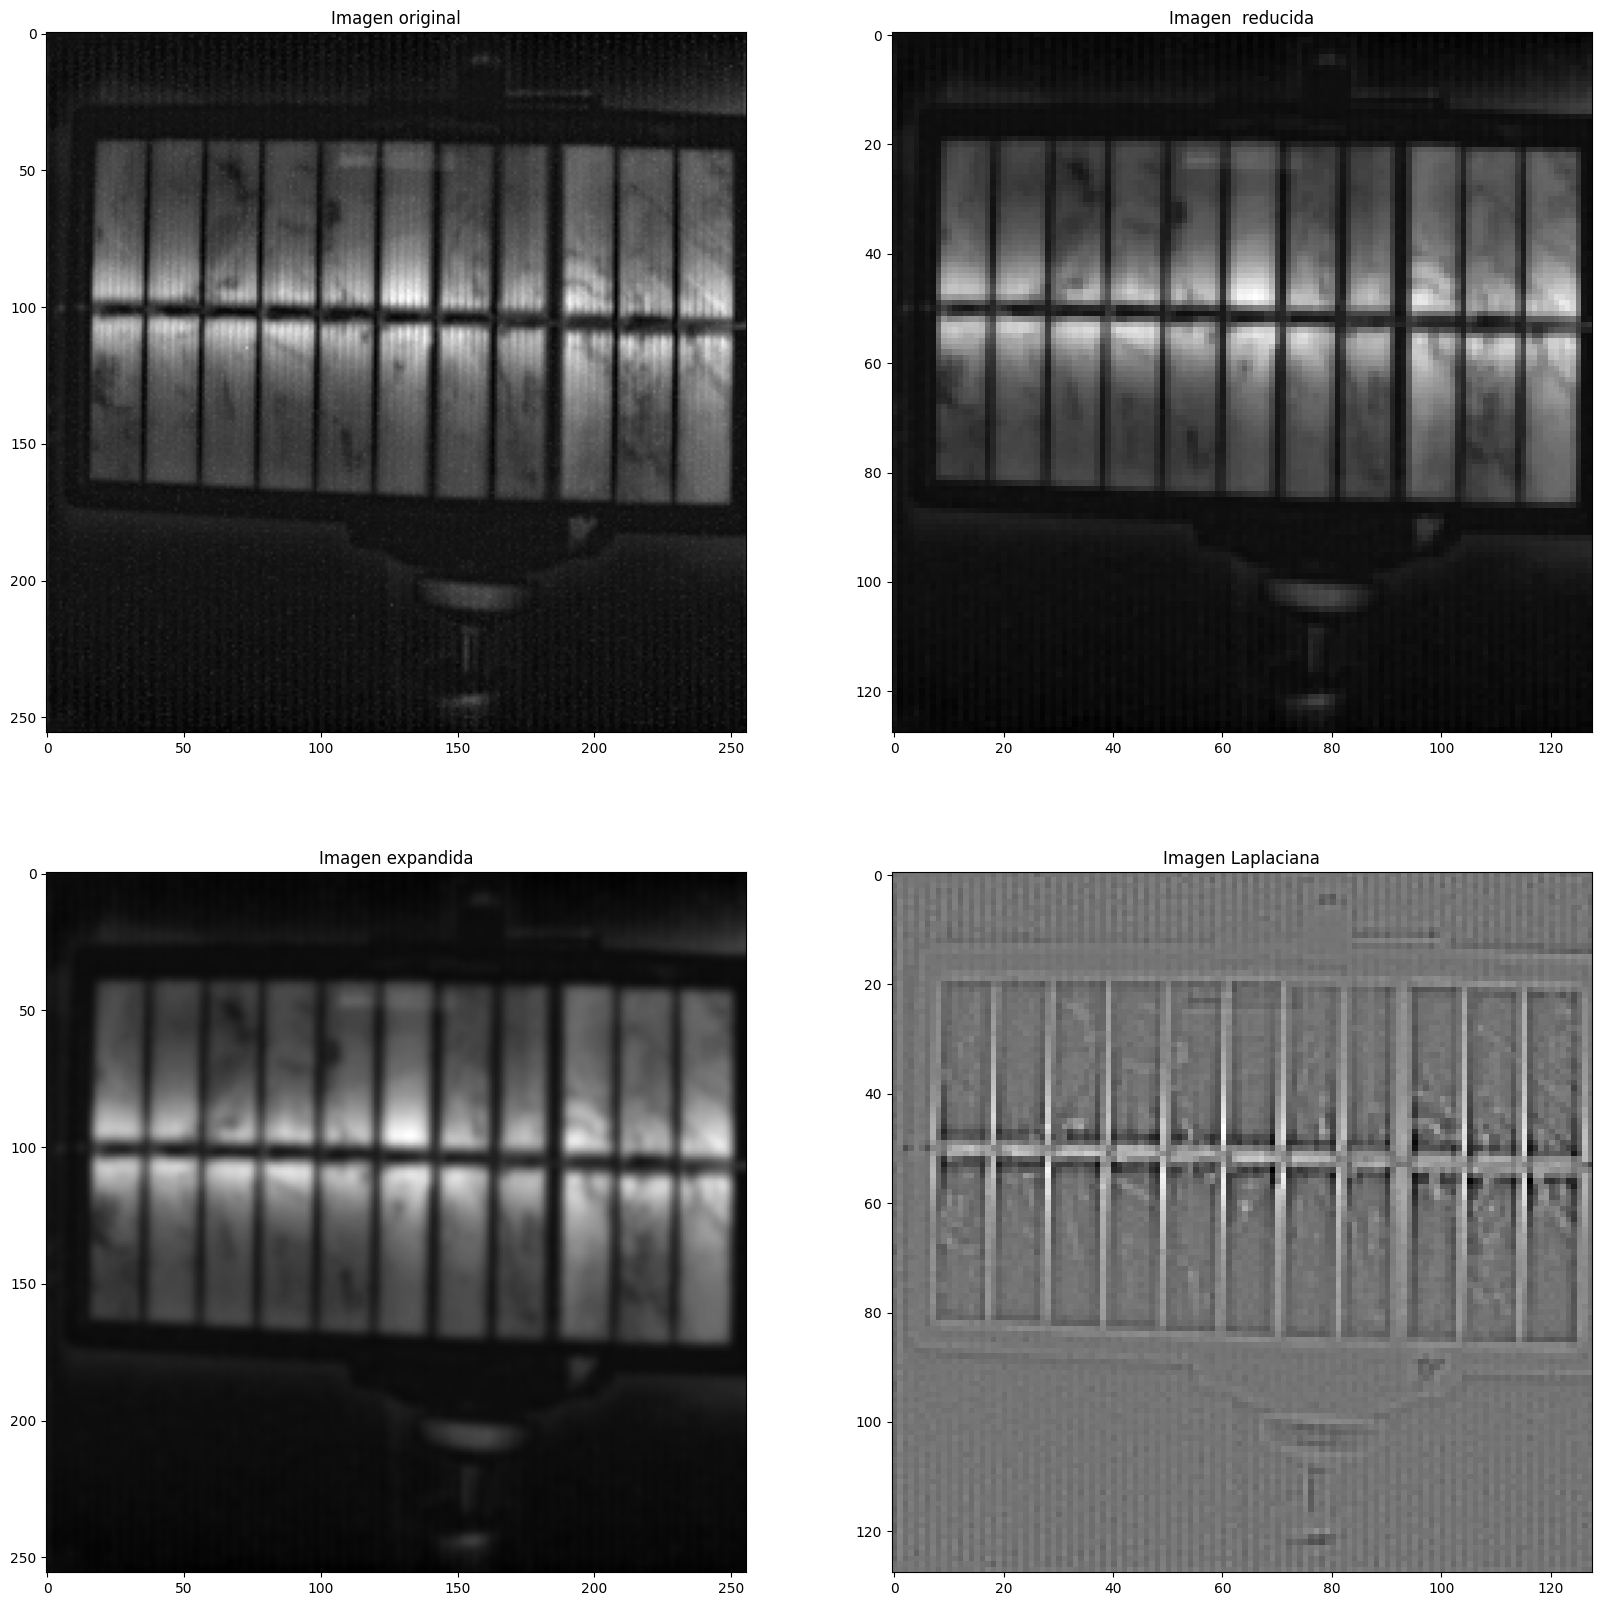

In [58]:
reduced = pyramids.pyramid_reduce(image_dataset[-1], sigma=None)    # Reduce la imagen
expanded = pyramids.pyramid_expand(reduced, sigma=None)             # Expande la imagen
red = pyramids.pyramid_reduce(expanded, sigma=None)                 # Reduce la imagen expandida
diff = red - reduced        # Calcula la diferencia entre las dos imágenes, imagen Laplaciana
# Imprime la dimensión del laplaciano
print("Dimensiones del laplaciano: ", diff.shape)
plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(image_dataset[-1], cmap="gray")
plt.title("Imagen original")

plt.subplot(222)
plt.imshow(reduced, cmap="gray")
plt.title("Imagen  reducida")

plt.subplot(223)
plt.imshow(expanded, cmap="gray")
plt.title("Imagen expandida")

plt.subplot(224)
plt.imshow(diff, cmap="gray")
plt.title("Imagen Laplaciana")

In [ ]:
# Suma de la imagen laplaciana con la imagen original para aumentar el contraste
laplacian = diff / np.max(diff) * 255
original = image_dataset[-1] / np.max(image_dataset[-1]) * 255

# Duplicación de la imagen Laplaciana
laplacian = cv2.resize(laplacian, (original.shape[1], original.shape[0]))

# Imprimir las dimensiones de las imágenes
print("Dimensiones de la imagen original: ", original.shape)
print("Dimensiones de la imagen Laplaciana: ", laplacian.shape)

# Suma de la imagen original con la imagen laplaciana
result = original + laplacian

# Normalización de la imagen resultante
result = result / np.max(result)

# Visualización de la imagen resultante
plt.figure(figsize=(10, 10))
plt.imshow(result, cmap="gray")
plt.title("Resultado de la suma de la imagen original con la imagen Laplaciana")

La clase `DWTSVD` es una clase que hereda de `Base`. Esta clase esta diseñada para realizar un tipo de mejora de imagen utilizando la Transformada Discreta de Wavelet (DWT) y la Descomposición en Valores Singulares (SVD).

La clase tiene dos métodos principales: `apply_enhancement` y `transform`.

1. `apply_enhancement(self, img)`: Este método toma una imagen como entrada y aplica una serie de transformaciones para mejorarla.

   - Primero, escala la imagen para que sus valores estén en el rango [0, 255] y luego aplica una ecualización de histograma. La ecualización de histograma es una técnica para ajustar el contraste de una imagen, de modo que su histograma se asemeje al de una imagen con un contraste óptimo.

   - Luego, aplica la DWT a la imagen ecualizada y a la imagen original, y descompone los coeficientes de la DWT en cuatro componentes: `LL`, `LH`, `HL` y `HH`.

   - A continuación, aplica la SVD a los componentes `LL` de la imagen original y de la imagen ecualizada.

   - Calcula un factor de escala `E` y un factor `alpha` basado en `E`, y luego utiliza estos factores para calcular una nueva matriz de valores singulares `S`.

   - Finalmente, utiliza la matriz `S` para mejorar el componente `LL` de la imagen original, y luego aplica la Transformada Inversa de Wavelet (IDWT) para obtener la imagen mejorada.

2. `transform(self, img)`: Este método parece ser una interfaz para aplicar la mejora a una imagen. Si el tamaño de la imagen es 1 o si el atributo `stage` de la clase es 0, simplemente aplica la mejora a la imagen. De lo contrario, decrementa el atributo `stage` y luego aplica la mejora a la imagen. El método luego recorta la imagen mejorada para que tenga las mismas dimensiones que la imagen original.

La clase `DWTSVD` parece ser una implementación de un algoritmo específico para la mejora de imágenes utilizando la DWT y la SVD.

In [62]:
class DWTSDV(Base):
    """
    Clase que implementa la transformada wavelet discreta con singular value decomposition. DWTSVD
    """
    def apply_enhancement(self, img):
        """
        Aplica la mejora de contraste a una imagen.

        Parámetros:
            img: Imagen a la que se le aplicará la mejora de contraste.

        Retorno:
            Imagen con la mejora de contraste aplicada.

        """
        scaling_factor = 255.0 / img.max()
        hist_img = cv2.equalizeHist(np.uint8(img * scaling_factor)) / scaling_factor

        coeffs2_hist = pywt.dwt2(hist_img, "bior1.3")
        LL_hist, _ = coeffs2_hist

        coeffs2 = pywt.dwt2(img, "bior1.3")
        LL, (LH, HL, HH) = coeffs2

        U, s, Vth = np.linalg.svd(LL)
        Ul, sl, Vlth = np.linalg.svd(LL_hist)

        E = np.max(sl) / np.max(s) # theory
        alpha = (E + 1 / E) / 4
        S = alpha * ((E * s) + (sl / E))
        sigma = np.diag(S)

        enhanced_LL = U @ sigma @ Vth

        coeffs2 = enhanced_LL, (LH, HL, HH)
        enhanced_img = pywt.idwt2(coeffs2, "bior1.3")
        return enhanced_img
    
    def transform(self, img):
        """
        Aplica la transformación wavelet discreta con singular value decomposition a una imagen.

        Parámetros:
            img: Imagen a la que se le aplicará la transformación.

        Retorno:
            Imagen con la transformación wavelet discreta con singular value decomposition aplicada.
        """
        if img.size == 1 or self.stage == 0:
            return self.apply_enhancement(img)
        self.stage -= 1

        ret = self.apply_enhancement(img)
        ret = ret[:img.shape[0], :img.shape[1]]
        return ret

Text(0.5, 1.0, 'Imagen original')

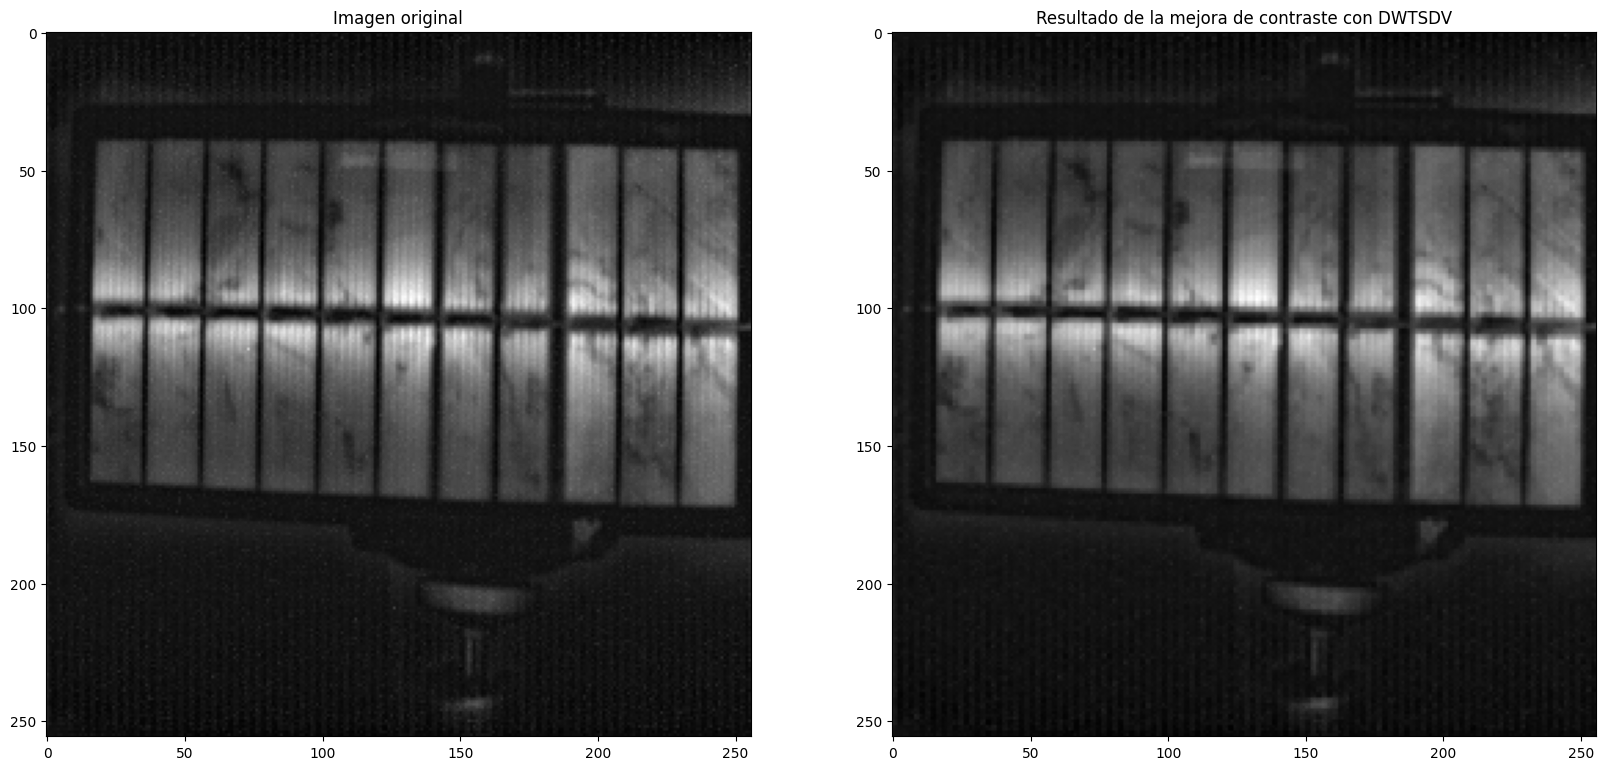

In [66]:
# Prueba de DWTSDV
panel1 = image_dataset[10]
model = DWTSDV(panel1, 5)
model.get_result()

plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 2)
plt.imshow(model.result, cmap="gray")
plt.title("Resultado de la mejora de contraste con DWTSDV")

plt.subplot(1, 2, 1)
plt.imshow(panel1, cmap="gray")
plt.title("Imagen original")

La clase `DWTSVDGaussianPyramidal` hereda de una clase base llamada `Base`. Esta clase parece estar diseñada para realizar un tipo de mejora de imagen utilizando la Transformada Discreta de Wavelet (DWT), la Descomposición en Valores Singulares (SVD) y una Pirámide Gaussiana.

La clase tiene dos métodos principales: `apply_enhancement` y `transform`.

1. `apply_enhancement(self, img)`: Este método es idéntico al de la clase `DWTSVD` que explicamos anteriormente. Toma una imagen como entrada y aplica una serie de transformaciones para mejorarla.

2. `transform(self, img)`: Este método es una extensión del método `transform` en la clase `DWTSVD`. Si el tamaño de la imagen es 1 o si el atributo `stage` de la clase es 0, simplemente aplica la mejora a la imagen. De lo contrario, decrementa el atributo `stage` y luego aplica una pirámide gaussiana a la imagen.

   - La pirámide gaussiana es una técnica que genera una serie de imágenes de menor resolución a partir de la imagen original. En este caso, se toma la segunda imagen en la pirámide (la imagen de menor resolución) y se aplica la transformación a esta imagen.

   - Luego, se expande la imagen transformada de vuelta a su tamaño original utilizando la función `pyramid_expand`. Esta imagen expandida se suma a la imagen original y el resultado se divide por 2 para obtener una imagen que es una combinación de la imagen original y la imagen transformada.

   - Finalmente, se aplica la mejora a esta imagen combinada y se recorta para que tenga las mismas dimensiones que la imagen original.

En resumen, la clase `DWTSVDGaussianPyramidal` parece ser una implementación de un algoritmo específico para la mejora de imágenes utilizando la DWT, la SVD y una pirámide gaussiana.

In [67]:
class DWTSVDGaussianPyramidal(Base):
    """
    Clase que implementa la transformada wavelet discreta con singular value decomposition y pirámide gaussiana.

    Atributos:
        stage: Número de etapas de la pirámide.
    """
    def apply_enhancement(self, img):
        """
        Aplica la mejora de contraste a una imagen.

        Parámetros:
            img: Imagen a la que se le aplicará la mejora de contraste.

        Retorno:
            Imagen con la mejora de contraste aplicada.
        """
        scaling_factor = 255.0 / img.max()
        hist_img = cv2.equalizeHist(np.uint8(img * scaling_factor)) / scaling_factor

        coeffs2_hist = pywt.dwt2(hist_img, "bior1.3")
        LL_hist, _ = coeffs2_hist

        coeffs2 = pywt.dwt2(img, "bior1.3")
        LL, (LH, HL, HH) = coeffs2

        U, s, Vth = np.linalg.svd(LL)
        Ul, sl, Vlth = np.linalg.svd(LL_hist)

        E = np.max(sl) / np.max(s)
        alpha = (E + 1 / E) / 4
        S = alpha * ((E * s) + (sl / E))
        sigma = np.diag(S)

        enhanced_LL = U @ sigma @ Vth

        coeffs2 = enhanced_LL, (LH, HL, HH)
        enhanced_img = pywt.idwt2(coeffs2, "bior1.3")
        return enhanced_img

    def transform(self, img):
        """
        Aplica la transformación wavelet discreta con singular value decomposition y pirámide gaussiana a una imagen.

        Parámetros:
            img: Imagen a la que se le aplicará la transformación.

        Retorno:
            Imagen con la transformación wavelet discreta con singular value decomposition y pirámide gaussiana aplicada.
        """
        if img.size == 1 or self.stage == 0:
            return self.apply_enhancement(img)
        self.stage -= 1
        img_pyramid = tuple(pyramids.pyramid_gaussian(img))[1]
        
        temp = self.transform(img_pyramid)

        res = pyramids.pyramid_expand(temp, sigma=None)
        ret = (res + img) / 2 # equal contrib for now
        ret = self.apply_enhancement(ret)
        ret = ret[:img.shape[0], :img.shape[1]]
        return ret

Text(0.5, 1.0, 'Imagen original')

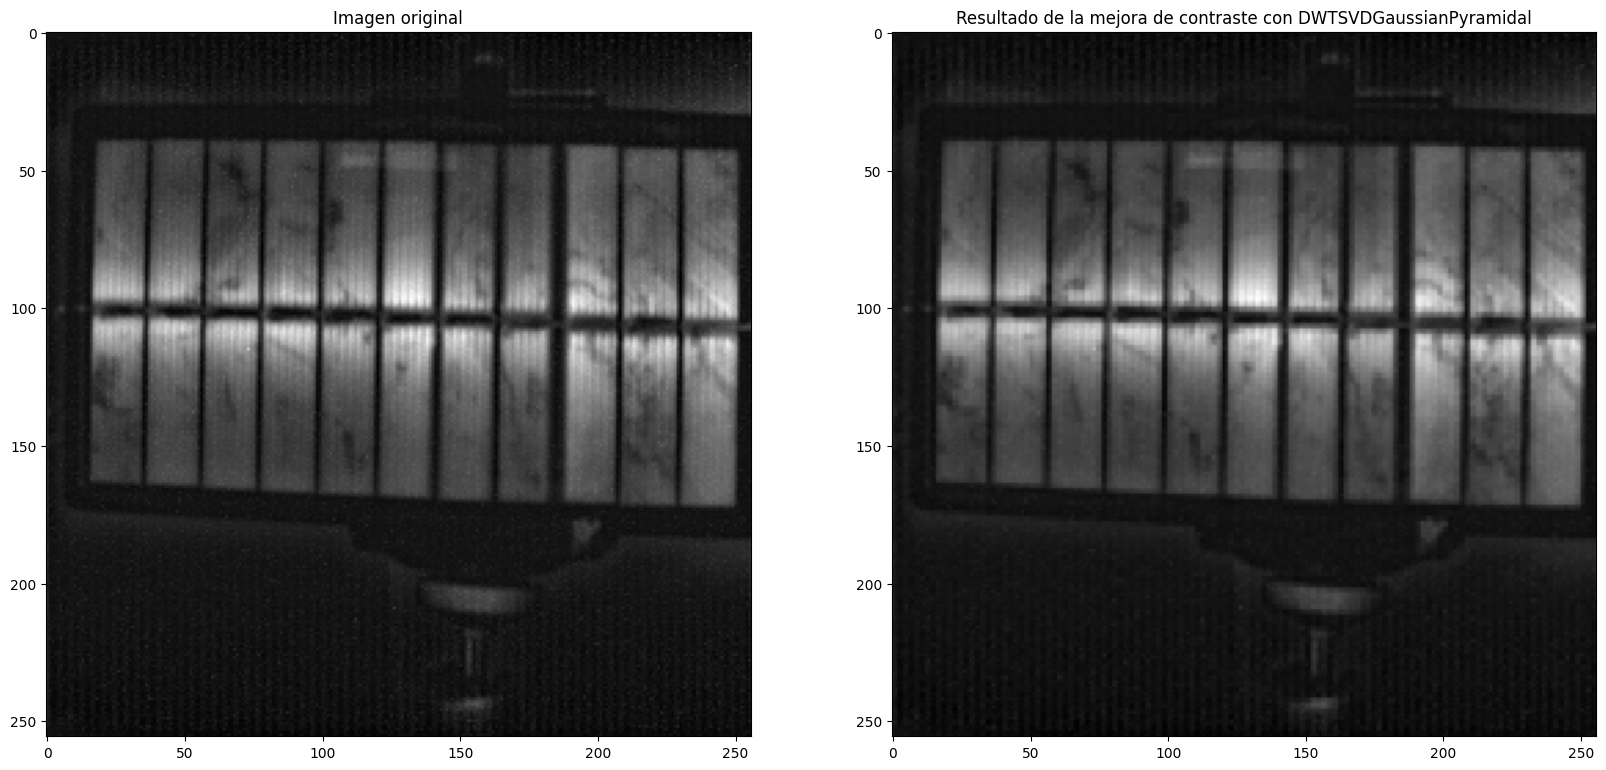

In [68]:
# Prueba de DWTSVDGaussianPyramidal

panel1 = image_dataset[10]
model = DWTSVDGaussianPyramidal(panel1, 5)
model.get_result()

plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 2)
plt.imshow(model.result, cmap="gray")
plt.title("Resultado de la mejora de contraste con DWTSVDGaussianPyramidal")

plt.subplot(1, 2, 1)
plt.imshow(panel1, cmap="gray")
plt.title("Imagen original")